<a href="https://colab.research.google.com/github/fppfurtado/mvp-pos-ciencia-de-dados/blob/main/Projeto_MVP_Preditor_de_Taxas_de_T%C3%ADtulos_P%C3%BAblicos_Federais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definição do Problema

## Objetivo
O presente projeto tem como objetivo a construção de um modelo de regressão linear para auxiliar o investidor a decidir o melhor momento de marcar a mercado seu título público, prevendo as taxas de juros ofertadas por títulos públicos federais - e, consequentemente, seus preços unitários - a partir dos valores da taxa de câmbio dolar/real (Ptax), do índice IBOVESPA e do CDS Brasil 5 anos.

## Títulos Públicos Federais
Títulos Públicos Federais são títulos de dívida emitidos pelo Governo Federal para financiar suas atvidades captando recursos de particulares em troca de pagamento de juros sobre um capital aplicado. Na prática, são **ativos de renda fixa** que possuem preço, taxa e vencimento definidos, e que podem ser adquiridos por investidores interessados.

Esses ativos possuem liquidez diária, podendo o investidor solicitar o resgate a qualquer tempo (durante o horário de funcionamento do mercado de títulos publicos), porém nesse caso o valor utilizado para o cálculo da rentabilidade será o **valor de mercado do título** no dia da solicitação de resgate, a chamada **Marcação a Mercado**, que pode fazer com que o investidor tenha ou lucro acima do esperado ou prejuízo no resgate antecipado.

O preço dos títulos públicos variam em função das respectivas taxas ofertadas. E as taxas variam diariamente, basicamente, em função da percepção de risco do mercado em relação à economia do país. Por isso, após alguma notícia negativa no cenário econômico, é comum observar fenômenos como "queda na bolsa", "alta no dolar" e "alta nos juros" pagos pelos títulos públicos federais.

## IBOVESPA
O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.

Reavaliado a cada quatro meses, o índice é resultado de uma carteira teórica de ativos. É composto pelas ações e units de companhias listadas na B3 que atendem aos critérios descritos na sua metodologia, correspondendo a cerca de 80% do número de negócios e do volume financeiro do nosso mercado de capitais.

Fonte: https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

## PTax
Ptax é uma taxa de câmbio calculada durante o dia pelo Banco Central do Brasil. Consiste na média das taxas de compra e de venda informadas pelas instituições financeiras durante 4 janelas do dia. É a taxa de referencia para o valor do dólar de D2 (em dois dias úteis). Normalmente, os contratos de derivativos de câmbio são liquidados com base na PTAX divulgada para o dia útil anterior.

Fonte: https://pt.wikipedia.org/wiki/Ptax

## CDS Brasil
CDS (credit default swap) é a troca de risco de crédito. O CDS é um contrato derivativo que funciona como um seguro para quem empresta dinheiro. Por levar em sua precificação o risco de inadimplência do tomador do empréstimo, o CDS é muito usado como termômetro para o risco de um país.

Fonte: https://inteligenciafinanceira.com.br/glossario/credit-default-swap-cds-risco-pais/

# 2. Coleta e Análise de Dados

## Importação de Pacotes e Módulos

In [395]:
# Importando pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

## Configurações prévias

In [396]:
# Suprimindo warnings
warnings.filterwarnings('ignore')

## Carregamento e Preparação

Serão carregados os datasets dos dados históricos das quatro variáveis econômicas que serão tratadas posteriormente pelo modelo de regressão linear: 

+ taxas e preços de título públicos federais
+ taxa de câmbio PTax
+ índice IBOVESPA
+ CDS Brasil 5 anos.

In [397]:
# Carregando o histórico de preços de preços e taxas de títulos públicos
historico_titulos = pd.read_csv('https://github.com/fppfurtado/mvp-pos-ciencia-de-dados/raw/main/DADOS/historico_titulos.csv', decimal = ',')
# Carregando o histórico do índice IBOVESPA
historico_ibov = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_ibov.csv', decimal = ',')
# Carregando o histórico da taxa de câmbio PTax
historico_ptax = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_ptax.csv', decimal = ',')
# Carregando o histórico do CDS Brasil 5 Anos
historico_cds5y = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_csd5y.csv', decimal = ',')

Cada dataset possui um conjunto de atributos próprio, muitos dos quais não serão relevantes em nosso projeto. Por esse motivo, selecionaremos apenas os atributos relevantes e faremos a junção em um dataset final de trabalho utilizando como chave os atributos temporais (datas).

In [398]:
# exibindo os nomes das colunas (atributos) dos datasets
print('atributos titulos:', historico_titulos.columns, '\n')
print('atributos ibov:', historico_ibov.columns, '\n')
print('atributos ptax:', historico_ptax.columns, '\n')
print('atributos cds5y:', historico_cds5y.columns, '\n')

atributos titulos: Index(['Tipo Titulo', 'Data Vencimento', 'Data Base', 'Taxa Compra Manha',
       'Taxa Venda Manha', 'PU Compra Manha', 'PU Venda Manha',
       'PU Base Manha'],
      dtype='object') 

atributos ibov: Index(['direction_color', 'rowDate', 'rowDateRaw', 'rowDateTimestamp',
       'last_close', 'last_open', 'last_max', 'last_min', 'volume',
       'volumeRaw', 'change_precent', 'last_closeRaw', 'last_openRaw',
       'last_maxRaw', 'last_minRaw', 'change_precentRaw'],
      dtype='object') 

atributos ptax: Index(['data', 'valor'], dtype='object') 

atributos cds5y: Index(['direction_color', 'rowDate', 'rowDateRaw', 'rowDateTimestamp',
       'last_close', 'last_open', 'last_max', 'last_min', 'volume',
       'volumeRaw', 'change_precent', 'last_closeRaw', 'last_openRaw',
       'last_maxRaw', 'last_minRaw', 'change_precentRaw'],
      dtype='object') 



Para o histórico de títulos públicos, selecionaremos os atributos: Tipo Titulo, Data Vencimento, Data Base, Taxa Venda Manha.

In [399]:
# reduzindo o dataset historico_titulos por meio da seleção de atributos relevantes
historico_titulos = historico_titulos[['Tipo Titulo', 'Data Vencimento', 'Data Base', 'Taxa Venda Manha']]

Para o histórico do Ibovespa, selecionaremos os atributos: rowDate, volumeRaw, change_precent.

In [400]:
# reduzindo o dataset historico_ibov por meio da seleção de atributos relevantes
historico_ibov = historico_ibov[['rowDate', 'volumeRaw', 'change_precent']]

Para o histórico da taxa de câmbio, como são apenas dois atributos, manteremos a mesma configuração.

Para o histórico do CDS Brasil 5 Anos, selecionaremos os atributos: rowDate, volumeRaw e change_precent.

In [401]:
# reduzindo o dataset historico_csd5y por meio da seleção de atributos relevantes
historico_cds5y = historico_cds5y[['rowDate', 'change_precent']]

Vamos garantir que os atributos temporais que sequenciam as séries históricas estejam armazenados como data, a fim de utilizá-los como chaves na junção dos datasets.

In [402]:
# ajustando tipos dos atributos temporais
historico_titulos['Data Base'] = historico_titulos['Data Base'].astype('datetime64')
historico_ibov['rowDate'] = historico_ibov['rowDate'].astype('datetime64')
historico_ptax['data'] = historico_ptax['data'].astype('datetime64')
historico_cds5y['rowDate'] = historico_cds5y['rowDate'].astype('datetime64')

Vamos agora juntar os datasets com base nos atributos temporais.

In [403]:
# mesclando o historico de titulos com o historico ibov com base em atributo de data
df_merge = pd.merge(historico_titulos, historico_ibov, left_on='Data Base', right_on='rowDate', suffixes=('_titulos', '_ibov'))
# mesclando o dataset df_merge com o historico ptax com base em atributo de data
df_merge = pd.merge(df_merge, historico_ptax, left_on='Data Base', right_on='data', suffixes=('_titulos', '_ptax'))
# mesclando o dataset df_merge com o historico CDS 5 anos com base em atributo de data
df_merge = pd.merge(df_merge, historico_cds5y, left_on='Data Base', right_on='rowDate', suffixes=('_ibov', '_cds'))
# exibindo as primeiras linhas para visualização do resultado
df_merge.head(5)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,rowDate_ibov,volumeRaw,change_precent_ibov,data,valor,rowDate_cds,change_precent_cds
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26


Por fim, vamos eliminar os atributos temporais duplicados e renomear alguns atributos.

In [404]:
# eliminando atributos irrelevantes
df_merge = df_merge.drop(columns=['rowDate_ibov', 'data', 'rowDate_cds'])
# renomeando atributos
df_merge = df_merge.rename(columns={
    'volumeRaw': 'Volume IBOV',
    'change_precent_ibov': 'Variação IBOV',
    'valor': 'Valor Dolar',
    'change_precent_cds': 'Variação CDS'
})
# exibindo as primeiras linhas
df_merge.head(5)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,7701390,0.46,5.0606,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,7701390,0.46,5.0606,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,7701390,0.46,5.0606,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,7701390,0.46,5.0606,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,7701390,0.46,5.0606,-1.26


## Análise Exploratória

Para a exploração dos dados dos datasets, seguiremos o seguinte roteiro para cada dataset:

1. Descrição e Classificação dos Dados Brutos
2. Estrutura do Dataset
3. Estatísticas Descritivas
4. Visualizações Unimodais
5. Visualizações Multimodais

### Estrutura do Dataset

In [405]:
# criando o dataset para a etapa de análise
df_analise = df_merge

Vamos iniciar a análise observando informações gerais sobre a estrutura do dataset de trabalho.

In [406]:
# exibindo informações gerais sobre o dataset
df_analise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28694 entries, 0 to 28693
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Tipo Titulo       28694 non-null  object        
 1   Data Vencimento   28694 non-null  object        
 2   Data Base         28694 non-null  datetime64[ns]
 3   Taxa Venda Manha  28694 non-null  object        
 4   Volume IBOV       28694 non-null  int64         
 5   Variação IBOV     28694 non-null  object        
 6   Valor Dolar       28694 non-null  object        
 7   Variação CDS      28694 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.0+ MB


O resumo acima nos informa as dimensões do dataset (28694 linhas, 08 colunas), os nomes de seus atributos, bem como seus respectivos tipos de dados e a quantidade de registros não-nulos (*missings*) para cada atributo.

Com a exceção dos atributos "Data Base" (tipo "datetime64") e "Volume IBOV" (tipo "int64"), todos os demais estão armazenados como "object" no dataset, que é uma tipagem genérica para texto, o que pode dificultar certas operações com os dados. Tal problema pode ser contornado com a conversão dos atributos para os tipos adequados.

É possível notar a falta de *missings* (valores nulos) nos atributos do dataset. Isso é explicado pela fato de o dataset não possuir dados oriundos de inputs de usuário (ex.: formulários), mas apenas dados computados automaticamente pelos sistemas de negociação dos respectivos ativos.

### Descrição e Classificação dos Dados Brutos

Agora vamos observar os dados brutos exibindo algumas linhas do dataset.

In [407]:
# exibindo linhas de fronteiras (início e fim) do dataset
df_analise

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,7701390,0.46,5.0606,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,7701390,0.46,5.0606,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,7701390,0.46,5.0606,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,7701390,0.46,5.0606,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,7701390,0.46,5.0606,-1.26
...,...,...,...,...,...,...,...,...
28689,Tesouro IPCA+ com Juros Semestrais,2020-08-15,2018-01-03,3.87,3239424,0.13,3.2614,-2.21
28690,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2018-01-03,4.2,3239424,0.13,3.2614,-2.21
28691,Tesouro Prefixado,2023-01-01,2018-01-03,9.8,3239424,0.13,3.2614,-2.21
28692,Tesouro Prefixado com Juros Semestrais,2021-01-01,2018-01-03,8.71,3239424,0.13,3.2614,-2.21


Observando os dados brutos, podemos classificar e descrever seus atributos:

+ <u>VARIÁVEL QUALITATIVA NOMINAL</u>
  + **Tipo Titulo**: o título público negociado.
+ <u>VARIÁVEL TEMPORAL</u>
  + **Data Vencimento**: a data de vencimento do título público.
  + **Data Base**: a data de referência da operação/negociação.
+ <u>VARIÁVEL QUANTITATIVA CONTÍNUA</u>
  + **Taxa Venda Manha**: a parte fixa da taxa de juros paga pelo título público.
  + **Volume IBOV**: o volume financeiro negociado pelas ações que compõem o índice Ibovespa.
  + **Variação IBOV**: o percentual de variação do índice Ibovespa em relação ao dia de negociação anterior.
  + **Valor Dolar**: o valor do dólar Ptax.
  + **Variação CDS**: o percentual de variação dos pontos-base do CDS Brasil 5 anos.

Abaixo podemos verificar quais tipos de títulos foram ofertados ao longo do período e a quantidade de ofertas associada a cada título.

In [408]:
# exibindo a quantidade registros por título
df_analise['Tipo Titulo'].value_counts()

Tesouro IPCA+ com Juros Semestrais        8100
Tesouro Prefixado com Juros Semestrais    5813
Tesouro Prefixado                         5337
Tesouro IPCA+                             4195
Tesouro Selic                             3456
Tesouro IGPM+ com Juros Semestrais        1793
Name: Tipo Titulo, dtype: int64

O título "Tesouro IGPM+" possui quantidade de registros significativamente inferior aos demais por ter sido ofertado pelo Tesouro Nacional até o ano de 2006.

In [409]:
# exibindo linhas de fronteiras (início e fim) do dataset ordenadas pelo atributo 'Data Base'
df_analise.sort_values('Data Base', ascending = False)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
4094,Tesouro IPCA+ com Juros Semestrais,2055-05-15,2022-12-29,6.23,13389109,-0.46,5.2171,-0.06
4101,Tesouro Prefixado,2024-07-01,2022-12-29,13.05,13389109,-0.46,5.2171,-0.06
4086,Tesouro Prefixado com Juros Semestrais,2023-01-01,2022-12-29,14.2,13389109,-0.46,5.2171,-0.06
4087,Tesouro Prefixado,2025-01-01,2022-12-29,12.71,13389109,-0.46,5.2171,-0.06
4088,Tesouro Prefixado com Juros Semestrais,2029-01-01,2022-12-29,12.82,13389109,-0.46,5.2171,-0.06
...,...,...,...,...,...,...,...,...
22817,Tesouro IPCA+,2035-05-15,2018-01-02,5.56,2969444,1.95,3.1724,-3.76
22816,Tesouro Selic,2021-03-01,2018-01-02,0.04,2969444,1.95,3.1724,-3.76
22815,Tesouro IPCA+ com Juros Semestrais,2035-05-15,2018-01-02,5.43,2969444,1.95,3.1724,-3.76
22814,Tesouro Prefixado,2019-01-01,2018-01-02,6.89,2969444,1.95,3.1724,-3.76


Verificamos pela tabela acima a coerência e abrangência temporal dos dados do atributo "Data Base", compreendendo o período de 02/01/2018 até 29/12/2022.

### Estatísticas Descritivas

Nesta seção vamos exibir as principais estatísticas descritivas dos atributos quantitativos da dataset. Mas para isso precisaremos primeiramente realizar algumas conversões de tipo, uma vez que vários atributos quantitativos estão armazenados como *object* (texto) no dataset.

In [410]:
# convertendo atributos do tipo "objetc" para os tipos adequados
df_analise = df_analise.astype({
    'Data Vencimento': 'datetime64',
    'Taxa Venda Manha': 'float64',
    'Variação IBOV': 'float64',
    'Valor Dolar': 'float64',
    'Variação CDS': 'float64'
})

Também será necessário criarmos uma nova coluna para classificar os títulos de acordo com o prazo até o vencimento, pois as taxas de juros apresentam comportamentos diferentes quanto maiores os prazos.

In [411]:
# função para classificar os prazos dos titulos
def classificarPrazo(qtdAnos):
  if(qtdAnos <= 1):
    return '1-curto'
  elif(qtdAnos <= 5):
    return '2-medio'
  else:
    return '3-longo'

# criando o atributo "Tipo Prazo" por meio da função classificarPrazo
df_analise['Tipo Prazo'] = (df_analise['Data Vencimento'] - df_analise['Data Base'])/np.timedelta64(1, 'Y')
df_analise['Tipo Prazo'] = df_analise['Tipo Prazo'].apply(classificarPrazo)

Vamos agora observar um resumo estatístico da variável "Taxa Venda Manha" para cada tipo de título ofertado.

In [412]:
# exibindo as estatísticas descritivas do atributo "Taxa Venda Manha" agrupadas por título.
df_analise.groupby(['Tipo Titulo', 'Tipo Prazo']).describe()['Taxa Venda Manha'].applymap('{:,.2f}'.format)

count   mean   std  \
Tipo Titulo                            Tipo Prazo                          
Tesouro IGPM+ com Juros Semestrais     1-curto       213.00  -0.83  1.74   
                                       2-medio       491.00   3.01  1.32   
                                       3-longo     1,089.00   4.51  1.06   
Tesouro IPCA+                          1-curto       221.00   2.25  1.22   
                                       2-medio     1,113.00   4.24  1.72   
                                       3-longo     2,861.00   4.61  1.00   
Tesouro IPCA+ com Juros Semestrais     1-curto       218.00   1.42  2.24   
                                       2-medio     1,391.00   4.10  1.61   
                                       3-longo     6,491.00   4.73  1.00   
Tesouro Prefixado                      1-curto     1,089.00   6.95  3.66   
                                       2-medio     3,444.00   8.43  2.78   
                                       3-longo       804.00   9.38  2.37   
Tesouro Prefixado com Juros Semestrais 1-curto       437.00   8.11  5.40   
                                       2-medio     2,178.00   8.45  2.68   
                                       3-longo     3,198.00   9.53  2.13   
Tesouro Selic                          1-curto       400.00   0.04  0.02   
                                       2-medio     2,562.00   0.09  0.07   
                                       3-longo       494.00   0.16  0.13   

                                                     min    25%    50%    75%  \
Tipo Titulo                            Tipo Prazo                               
Tesouro IGPM+ com Juros Semestrais     1-curto     -3.30  -2.14  -0.85   0.25   
                                       2-medio      0.50   2.01   3.21   4.06   
                                       3-longo      2.65   3.45   4.47   5.58   
Tesouro IPCA+                          1-curto     -1.42   2.17   2.56   3.08   
                                       2-medio      1.32   2.51   4.59   5.69   
                                       3-longo      2.16   3.80   4.55   5.49   
Tesouro IPCA+ com Juros Semestrais     1-curto     -3.00  -0.06   1.29   2.28   
                                       2-medio      1.24   2.78   3.94   5.59   
                                       3-longo      2.02   4.01   4.64   5.69   
Tesouro Prefixado                      1-curto      1.95   4.66   6.48   7.25   
                                       2-medio      2.75   6.34   8.23  10.73   
                                       3-longo      5.96   7.06   9.05  11.79   
Tesouro Prefixado com Juros Semestrais 1-curto      1.89   2.19  11.93  13.78   
                                       2-medio      3.76   6.21   8.21  10.94   
                                       3-longo      5.93   7.44   9.32  11.55   
Tesouro Selic                          1-curto      0.01   0.02   0.03   0.05   
                                       2-medio      0.01   0.03   0.05   0.15   
                                       3-longo      0.03   0.03   0.06   0.30   

                                                     max  
Tipo Titulo                            Tipo Prazo         
Tesouro IGPM+ com Juros Semestrais     1-curto      5.08  
                                       2-medio      5.27  
                                       3-longo      6.54  
Tesouro IPCA+                          1-curto      3.73  
                                       2-medio      7.38  
                                       3-longo      6.59  
Tesouro IPCA+ com Juros Semestrais     1-curto      7.13  
                                       2-medio      7.43  
                                       3-longo      6.57  
Tesouro Prefixado                      1-curto     14.20  
                                       2-medio     14.31  
                                       3-longo     13.80  
Tesouro Prefixado com Juros Semestrais 1-curto     14.20  
                           

É comum agrupar os títulos de acordo com o tipo de rentabilidade: prefixada, pós-fixada, ou indexada à inflação. Por isso, vamos estratificar a análise dos títulos criando uma coluna nova para fazer a classificação por rentabilidade.

In [413]:
# função para classificar a rentabilidade do titulo
def classificarTitulo(titulo):
  if 'Selic' in titulo:
    return 'Pós-fixado'
  elif 'Prefixado' in titulo:
    return 'Prefixado'
  else:
    return 'Inflação'

# criando a coluna Tipo Rentabilidade por meio da função classificarTitulo
df_analise['Tipo Rentabilidade'] = df_analise['Tipo Titulo'].apply(classificarTitulo)
# exibe o dataframe
df_analise

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS,Tipo Prazo,Tipo Rentabilidade
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,7701390,0.46,5.0606,-1.26,3-longo,Prefixado
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,7701390,0.46,5.0606,-1.26,3-longo,Inflação
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,7701390,0.46,5.0606,-1.26,2-medio,Inflação
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.30,7701390,0.46,5.0606,-1.26,1-curto,Inflação
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,7701390,0.46,5.0606,-1.26,2-medio,Prefixado
...,...,...,...,...,...,...,...,...,...,...
28689,Tesouro IPCA+ com Juros Semestrais,2020-08-15,2018-01-03,3.87,3239424,0.13,3.2614,-2.21,2-medio,Inflação
28690,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2018-01-03,4.20,3239424,0.13,3.2614,-2.21,2-medio,Inflação
28691,Tesouro Prefixado,2023-01-01,2018-01-03,9.80,3239424,0.13,3.2614,-2.21,2-medio,Prefixado
28692,Tesouro Prefixado com Juros Semestrais,2021-01-01,2018-01-03,8.71,3239424,0.13,3.2614,-2.21,2-medio,Prefixado


Agora vamos reexibir as estatísticas descritivas, agora agrupadas por tipo de rentablidade.

In [414]:
# exibindo as estatísticas descritivas do atributo "Taxa Venda Manha" agrupadas por tipo de rentabildiade.
df_analise.groupby(['Tipo Rentabilidade', 'Tipo Prazo']).describe()['Taxa Venda Manha'].applymap('{:,.2f}'.format)

count  mean   std    min    25%   50%  \
Tipo Rentabilidade Tipo Prazo                                              
Inflação           1-curto        652.00  0.97  2.20  -3.30  -0.68  1.29   
                   2-medio      2,995.00  3.97  1.67   0.50   2.55  3.85   
                   3-longo     10,441.00  4.67  1.01   2.02   3.90  4.60   
Prefixado          1-curto      1,526.00  7.28  4.26   1.89   4.00  6.48   
                   2-medio      5,622.00  8.44  2.74   2.75   6.28  8.22   
                   3-longo      4,002.00  9.50  2.18   5.93   7.36  9.30   
Pós-fixado         1-curto        400.00  0.04  0.02   0.01   0.02  0.03   
                   2-medio      2,562.00  0.09  0.07   0.01   0.03  0.05   
                   3-longo        494.00  0.16  0.13   0.03   0.03  0.06   

                                 75%    max  
Tipo Rentabilidade Tipo Prazo                
Inflação           1-curto      2.54   7.13  
                   2-medio      5.52   7.43  
                   3-longo      5.64   6.59  
Prefixado          1-curto     12.53  14.20  
                   2-medio     10.83  14.31  
                   3-longo     11.61  13.82  
Pós-fixado         1-curto      0.05   0.16  
                   2-medio      0.15   0.38  
                   3-longo      0.30   0.36

Nota-se que o título com maior desvio padrão são os título do tipo "Prefixado", o que possivelmente indica uma maior volatilidade (risco) dessa categoria de ativo. Esse tipo de característica é considerada importante nos casos de marcação a mercado, pois possibilita maior lucro (ou prejuízo).

A partir de agora vamos desenvolver nossas análises a partir dessas duas categorias: tipo de prazo e tipo de rentabilidade.

In [415]:
# calculando a amplitude de taxa por tipo de título e de prazo
max_titulo_prazo = pd.DataFrame(df_analise.groupby(['Tipo Rentabilidade', 'Tipo Prazo']).describe()['Taxa Venda Manha']['max']).pivot_table(index='Tipo Rentabilidade', columns='Tipo Prazo', values='max')
min_titulo_prazo = pd.DataFrame(df_analise.groupby(['Tipo Rentabilidade', 'Tipo Prazo']).describe()['Taxa Venda Manha']['min']).pivot_table(index='Tipo Rentabilidade', columns='Tipo Prazo', values='min')
max_titulo_prazo - min_titulo_prazo

Tipo Prazo,1-curto,2-medio,3-longo
Tipo Rentabilidade,,,
Inflação,10.43,6.93,4.57
Prefixado,12.31,11.56,7.89
Pós-fixado,0.15,0.37,0.33


Acima podemos observar as amplitudes das taxas por tipo de prazo para cada tipo de título. Os títulos do tipo "Prefixado" apresentam o maior valor de amplitude, o que combinado com sua característica de maior desvio padrão, confirma sua característica de categoria mais volátil do grupo.

In [416]:
# exibindo as estatísticas descritivas dos demais atributos quantitativos
df_analise.describe()[['Volume IBOV', 'Valor Dolar', 'Variação IBOV', 'Variação CDS']].applymap('{:,.2f}'.format)

,Volume IBOV,Valor Dolar,Variação IBOV,Variação CDS
count,"28,694.00","28,694.00","28,694.00","28,694.00"
mean,"8,617,119.96",4.72,0.04,0.08
std,"4,080,040.44",0.76,1.77,3.57
min,"424,315.00",3.14,-14.78,-25.88
25%,"4,933,512.00",3.94,-0.79,-1.39
50%,"8,584,901.00",5.09,0.08,-0.01
75%,"11,476,269.00",5.34,0.98,1.27
max,"26,029,316.00",5.94,13.91,30.61


Acima o resumo estatísticos dos demais atributos quantitativos do dataset. Chama a atenção os valores do atributo "Variação CDS", onde podemos notar como o desvio padrão é relativamente alto em relação à média e como o terceiro quartil está distante do valor máximo, indicando que esse provavelmente é um indicador bastante volátil.

### Visualizações Unimodais

Agora vamos observar graficamente o comportamento das taxas dos títulos por tipo de prazo.

In [417]:
# cria um dicionario com os dados para plotar os histogramas dos tipos titulos por tipo de prazo
dados_histograma = {}

# itera sobre os tipos de rentabilidade
for tipo in df_analise['Tipo Rentabilidade'].unique():
  # para cada tipo de rentabilidade (chave), guarda no dicionario os dados por tipo de prazo
  dados_histograma[tipo] = df_analise[df_analise['Tipo Rentabilidade'] == tipo].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')

Vamos exibir os histogramas dos títulos por tipo de prazo, plotando-os todos num só gráfico para fins de comparação.

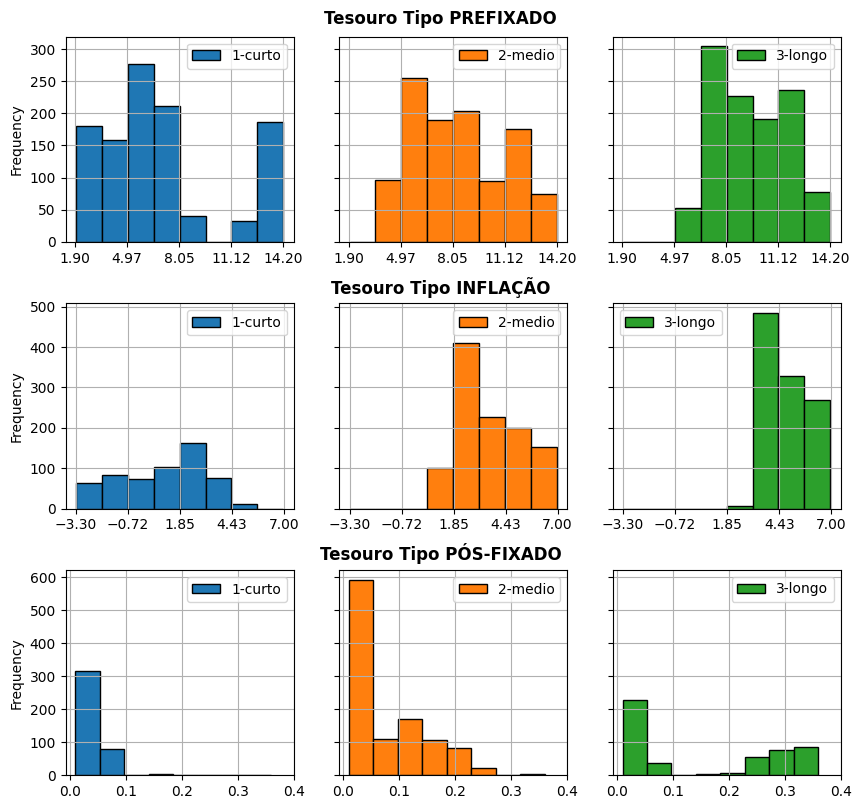

In [418]:
# exibindo os boxplots dos atributos quantitativos

fig = plt.figure(figsize=(10,8))

qtd_grupos_titulos = len(dados_histograma.keys())
# cria subfiguras para os tipos de rentabilidade
subfigs = fig.subfigures(qtd_grupos_titulos, 1)

ax =[]
cont = 0

# itera sobre os dados para o histogramas
for grupo, dados in dados_histograma.items():

  # armazena os eixos das subfiguras
  ax.append(subfigs[cont].subplots(1,1))
  # pega o valor maximo
  maximo = round(max(dados.max()),1)
  # pega o valor minimo
  minimo = round(min(dados.min()),1)
  # estabelece um passo dentro do intervalo entre maximo e minimo
  passo = (maximo-minimo)/4
  # plota os histogramas
  dados.plot(kind='hist', subplots=True, layout=(1,3), edgecolor='black',sharex=True, sharey=True, bins=8, grid=True, ax = ax[cont])
  # ajusta os valores no eixo x
  plt.xticks(np.arange(minimo, maximo+passo*0.1, passo))
  # define o titulo superior
  subfigs[cont].suptitle('Tesouro Tipo ' + grupo.upper(), fontweight='bold')
  cont += 1

Na matriz acima vemos como a concentração de títulos com rentabilidade maior vai aumentando conforme o prazo fica mais longo (vencimento mais distante), pois quanto maior o risco, maior o prêmio na rentabilidade.

Também é possível ver que há taxas com valores negativos. Apesar de ser um pouco incomum, é uma situação possível de acontecer.

Na sequencia, vamos organizar os dados para plotar os boxplots das taxas por tipo de rentabilidade e tipo de prazo.

In [419]:
# cria um dicionario com os dados para plotar os boxplots dos tipos de titulos por tipo de prazo

dados_boxplot = {}
dados_por_prazo = []

# a partir dos dados do histograma
for grupo, dados in dados_histograma.items():
  # para cada tipo de prazo
  for prazo in dados.columns:
    # guarda na lista os dados por tipo de prazo, excluindo os missings
    dados_por_prazo.append(dados[prazo].dropna())
  # guarda a lista no dicionario
  dados_boxplot[grupo] = dados_por_prazo
  # limpa a lista
  dados_por_prazo = []


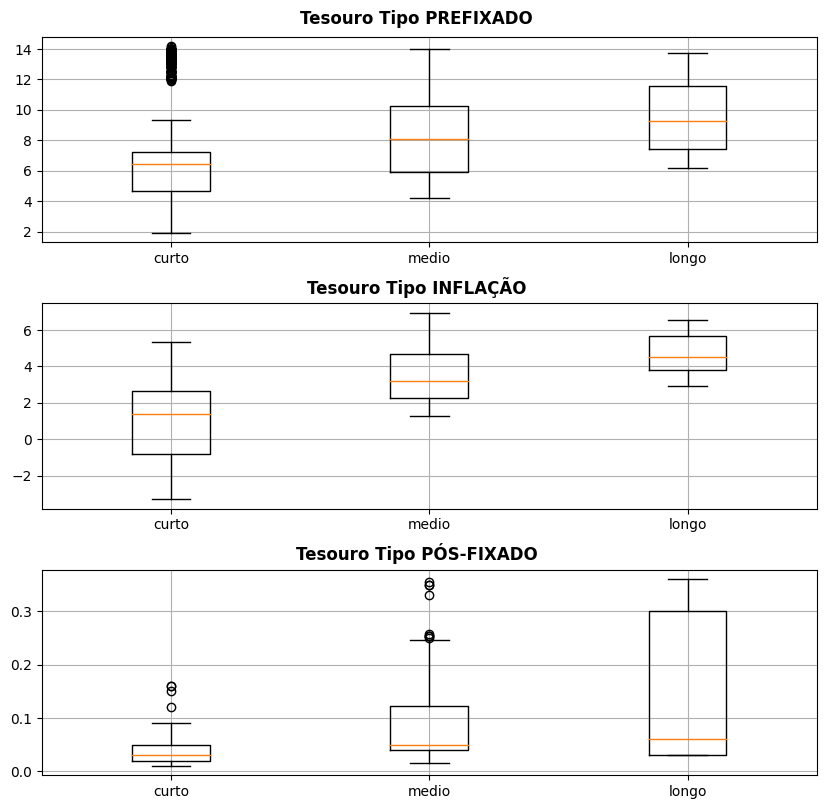

In [420]:
# exibindo os boxplots dos atributos quantitativos

fig = plt.figure(figsize=(10,8))

qtd_grupos_titulos = len(dados_boxplot.keys())
# cria subfiguras para os tipos de rentabilidade
subfigs = fig.subfigures(qtd_grupos_titulos, 1)

ax =[]
cont = 0

# itera sobre os dados para o boxplots
for grupo, dados in dados_boxplot.items():

  # armazena os eixos das subfiguras
  ax.append(subfigs[cont].subplots(1,1))
  # plota os dados em boxplot
  plt.boxplot(dados)
  # habilita grid
  plt.grid(True)
  # altera os values do eixo x
  plt.xticks([1,2,3], ['curto', 'medio', 'longo'])
  # deifne o texto superior da subfigura da vez
  subfigs[cont].suptitle('Tesouro Tipo ' + grupo.upper(), fontweight='bold')
  cont += 1

Nos boxplots acima, chama a atenção os gráficos de variação (IBOV e CDS) com característica "espremida", exibindo uma grande quantidade de outliers (dados discrepantes da maioria) nos conjuntos de dados. Como já comentado anteriormente, tais dados não podem ser considerados inputs errados pela própria natureza dos datasets. 

Nesse caso, não é prudente eliminar tais registros, uma vez que eles provavelmente capturam uma parte do comportamento real dos atributos. O que poderá ser feito posteriormente é testar um tratamento à parte desses outliers junto aos modelos estatísticos para avaliar qual a melhor opção.

### Visualizações Multimodais

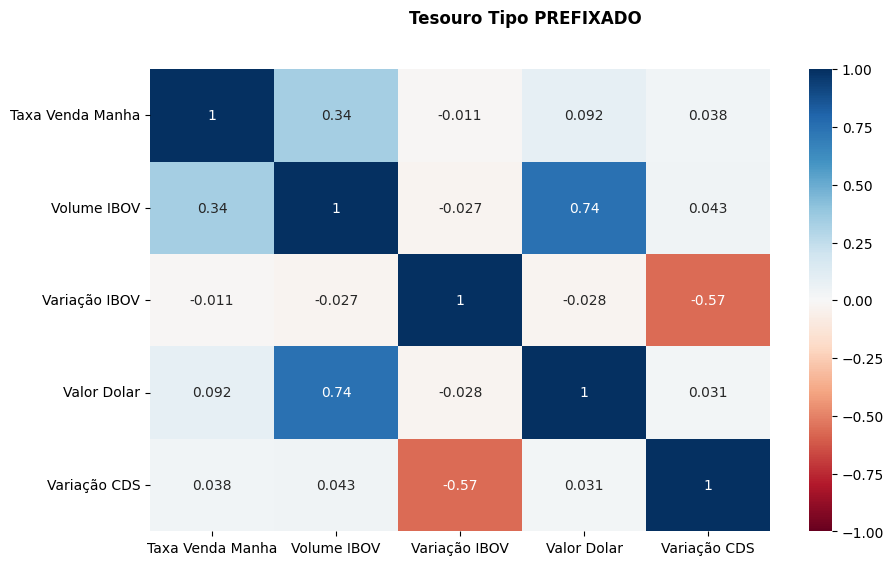

In [421]:
# matriz de correlação dos atributos para os títulos com rentabilidade do tipo PREFIXADO
fig = plt.figure(figsize = (10,6))
fig.suptitle('Tesouro Tipo PREFIXADO', fontweight='bold')
sns.heatmap(df_analise[(df_analise['Tipo Rentabilidade'] == 'Prefixado')].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

Para os títulos com rentabilidade PREFIXADA, é possível observar correlação positiva significativa entre os atributos "Valor Dolar" e "Volume IBOV", bem como correlação negativa significativa entre os atributos "Variação CDS" e "Variação IBOV". Além disso, é possível observar leve correlação positiva entre os atributos "Volume IBOV" e "Taxa Venda Manha".

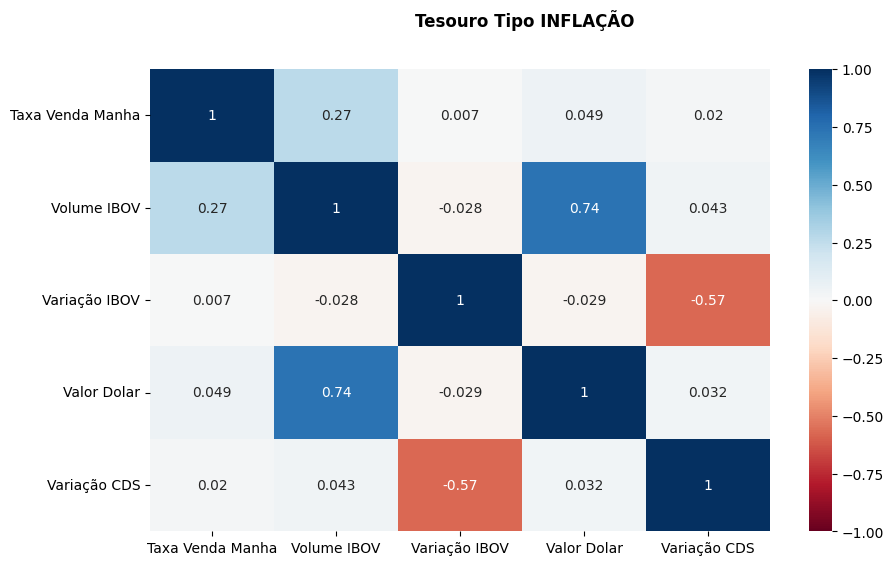

In [422]:
# matriz de correlação dos atributos para os títulos com rentabilidade do tipo INFLAÇÃO
fig = plt.figure(figsize = (10,6))
fig.suptitle('Tesouro Tipo INFLAÇÃO', fontweight='bold')
sns.heatmap(df_analise[(df_analise['Tipo Rentabilidade'] == 'Inflação')].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

Para os títulos com rentabilidade INFLAÇÃO, é possível observar correlação positiva significativa entre os atributos "Valor Dolar" e "Volume IBOV", bem como correlação negativa significativa entre os atributos "Variação CDS" e "Variação IBOV". Além disso, é possível observar leve correlação positiva entre os atributos "Volume IBOV" e "Taxa Venda Manha".

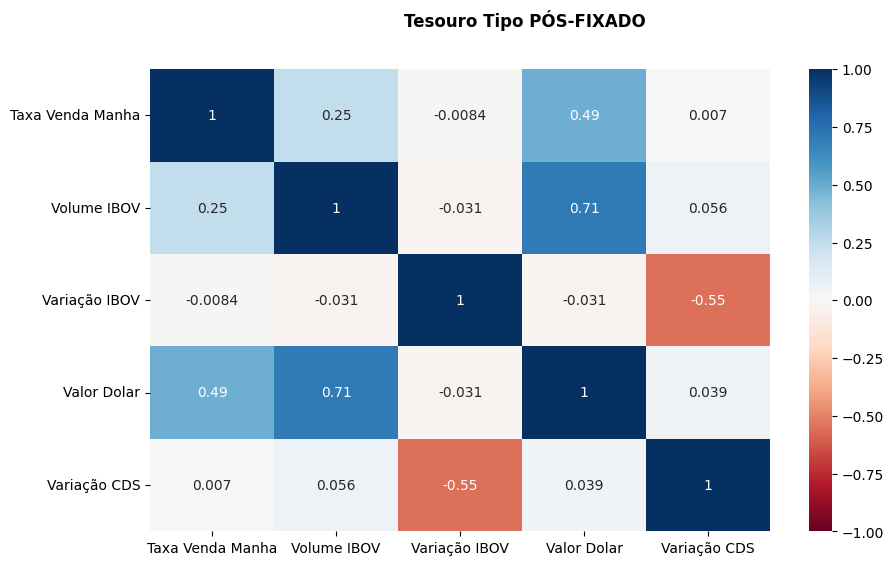

In [423]:
# matriz de correlação dos atributos para os títulos com rentabilidade do tipo PÓS-FIXADO
fig = plt.figure(figsize = (10,6))
fig.suptitle('Tesouro Tipo PÓS-FIXADO', fontweight='bold')
sns.heatmap(df_analise[(df_analise['Tipo Rentabilidade'] == 'Pós-fixado')].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

Para os títulos com rentabilidade PÓS-FIXADA, é possível observar correlação positiva significativa entre os atributos "Valor Dolar" e "Volume IBOV" e entre "Valor Dolar" e " Taxa Venda Manha", bem como correlação negativa significativa entre os atributos "Variação CDS" e "Variação IBOV". Além disso, é possível observar leve correlação positiva entre os atributos "Volume IBOV" e "Taxa Venda Manha".

# 3. Pré-Processamento

## Importação de Pacotes e Módulos

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Carregamento e Preparação

In [425]:
# criando o dataset para a etapa de análise
df_preproc = df_analise

## Pré-Processamento

Nesta etapa, realizaremos operações de limpeza, conversão, substituição, transformação de dados, e outras que se fizerem necessárias, para preparar os dados para serem submetidos aos modelos de machine learning posteriormente.

Vamos observar novamente a estrutura do dataset a fim de verificar se há algum ajuste ou simplificação que possa ser feito no mesmo.

In [426]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28694 entries, 0 to 28693
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Tipo Titulo         28694 non-null  object        
 1   Data Vencimento     28694 non-null  datetime64[ns]
 2   Data Base           28694 non-null  datetime64[ns]
 3   Taxa Venda Manha    28694 non-null  float64       
 4   Volume IBOV         28694 non-null  int64         
 5   Variação IBOV       28694 non-null  float64       
 6   Valor Dolar         28694 non-null  float64       
 7   Variação CDS        28694 non-null  float64       
 8   Tipo Prazo          28694 non-null  object        
 9   Tipo Rentabilidade  28694 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(1), object(3)
memory usage: 2.4+ MB


Ao analisar as informações acima, verificamos que não existem missings para serem eliminados ou substituídos. 

As conversões de dados que eram necessárias já foram feitas na etapa anterior a fim de viabilizar a continuidade da mesma. 

Por outro lado, na etapa de análise criamos dois atributos derivados (feature egineering) para categorizar e agrupar registros semelhantes: Tipo Prazo e Tipo Rentabilidade. Os respectivos atributos de origem - Tipo Titulo, Data Vencimento, Data Base - podem ser substituídos pelos seus derivados, que simplificam e capturam melhor as características de interesse do problema. 

In [427]:
# Feature Selection: eliminando atributos desnecessários
df_preproc = df_preproc.drop(['Tipo Titulo', 'Data Base', 'Data Vencimento'], axis=1)
df_preproc.head(5)

,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS,Tipo Prazo,Tipo Rentabilidade
0,6.97,7701390,0.46,5.0606,-1.26,3-longo,Prefixado
1,2.54,7701390,0.46,5.0606,-1.26,3-longo,Inflação
2,1.79,7701390,0.46,5.0606,-1.26,2-medio,Inflação
3,-0.30,7701390,0.46,5.0606,-1.26,1-curto,Inflação
4,4.61,7701390,0.46,5.0606,-1.26,2-medio,Prefixado


Uma questão interessante a considerar é a possibilidade de eliminar atributos com correlação relativamente baixa com o atributo alvo (Taxa Venda Manha). A princípio, não eliminaremos tais atributos antes de analisar os resultados do modelo preditivo.

Por fim, o que restou é a necessidade de transformação dos valores dos atributos quantitativos a fim de ajustar suas escalas; o mapeamento dos atributos qualitativos em atributos quantitativos; a separação do dataset em treinamento e teste para construção do modelo de machine learning.

Sendo assim, seguiremos o seguinte roteiro na etapa de Pré-Processamento:


1. Separação do dataset em treino e teste
2. Transformação dos atributos qualitativos
3. Transformação dos atributos quantitativos

### Amostragem do Dataset (Treino e Teste)

Vamos começar selecionando as características e a variável alvo (target) do modelo.

In [428]:
# variável alvo do modelo
Y = df_preproc['Taxa Venda Manha']
# variáveis características do modelo
X = df_preproc.drop('Taxa Venda Manha', axis=1)

In [429]:
# separando o dataset em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, random_state = 0)

Essa separação é necessária antes dos processos de transformação dos dados para evitar vazamento de dados (*data leakage*).

### Transformação dos Atributos Qualitativos

Para o atributo categórico 'Tipo Prazo' vamos aplicar transformação **ordinal** já que seus valores possuem uma ordem implícita.

In [430]:
# cria dicionario com as correspondencias ordinais
prazo_map = {'1-curto': 1, '2-medio': 2, '3-longo': 3}
# aplica a transformação ordinal
X_treino['Tipo Prazo'] = X_treino['Tipo Prazo'].map(prazo_map)
X_teste['Tipo Prazo'] = X_teste['Tipo Prazo'].map(prazo_map)
# exibe os datasets
print('X Treino: \n\n', X_treino['Tipo Prazo'])
print('X Teste: \n\n', X_teste['Tipo Prazo'])

X Treino: 

 29       2
5356     3
11158    2
27568    2
7394     1
        ..
13123    3
19648    2
9845     3
10799    1
2732     2
Name: Tipo Prazo, Length: 21520, dtype: int64
X Teste: 

 18546    3
17550    2
28151    3
3254     2
11204    2
        ..
613      3
2518     2
7655     3
20144    3
12239    2
Name: Tipo Prazo, Length: 7174, dtype: int64


Para o atributo 'Tipo Rentabilidade' vamos aplicar a transformação **OneHotEncoding** já que seus valores não possuem ordem implícita.

In [431]:
# transforma o atributo 'Tipo Rentabilidade' com a técnica OneHotEncoding
X_treino = pd.get_dummies(X_treino, columns=['Tipo Rentabilidade'], prefix='', prefix_sep='')
X_teste = pd.get_dummies(X_teste, columns=['Tipo Rentabilidade'], prefix='', prefix_sep='')
# exibe os datasets
print('X Treino: \n\n', X_treino.iloc[:,-3:])
print('X Teste: \n\n', X_teste.iloc[:,-3:])

X Treino: 

        Inflação  Prefixado  Pós-fixado
29            0          1           0
5356          1          0           0
11158         0          0           1
27568         0          0           1
7394          0          1           0
...         ...        ...         ...
13123         1          0           0
19648         1          0           0
9845          1          0           0
10799         0          1           0
2732          0          0           1

[21520 rows x 3 columns]
X Teste: 

        Inflação  Prefixado  Pós-fixado
18546         1          0           0
17550         0          1           0
28151         1          0           0
3254          1          0           0
11204         1          0           0
...         ...        ...         ...
613           0          1           0
2518          0          1           0
7655          1          0           0
20144         1          0           0
12239         0          0           1

[7174 rows x

### Transformação dos Atributos Quantitativos

Como as distribuições das estratificações por rentabilidade não correspondiam exatamente à distribuição, vamos aplicar o processo de **normalização** nas variáveis quantitativas, a fim de ajustar o seu intervalo de valores para ser lido pelo modelo.

In [432]:
# escolhendo as colunas para normalização
colunas = [
    'Volume IBOV',
    'Variação IBOV',
    'Valor Dolar',
    'Variação CDS',
    'Tipo Prazo'
]

# instanciando o normalizador
scaler = MinMaxScaler()
# aplicando a normalização
X_treino[colunas] = scaler.fit_transform(X_treino[colunas])
X_teste[colunas] = scaler.fit_transform(X_teste[colunas])
# exibe os datasets
print('X Treino: \n\n', X_treino)
print('X Teste: \n\n', X_teste)

X Treino: 

        Volume IBOV  Variação IBOV  Valor Dolar  Variação CDS  Tipo Prazo  \
29        0.562348       0.553154     0.786942      0.547176         0.5   
5356      0.355054       0.557337     0.712342      0.458134         1.0   
11158     0.440850       0.509934     0.852231      0.458488         0.5   
27568     0.138368       0.542001     0.298761      0.434944         0.5   
7394      0.320152       0.562565     0.812764      0.470703         0.0   
...            ...            ...          ...           ...         ...   
13123     0.266069       0.544789     0.638457      0.428571         1.0   
19648     0.152407       0.585221     0.085739      0.442910         0.5   
9845      0.322628       0.510979     0.865876      0.440786         1.0   
10799     0.459540       0.522482     0.792350      0.464330         0.0   
2732      0.638512       0.578947     0.777523      0.499026         0.5   

       Inflação  Prefixado  Pós-fixado  
29            0          1       

Desta forma, temos então o dataset devidamente preparado e dividido para ser utilizado na construção de modelos de machine learning.